Epoch 1/10
1/1 - 2s - loss: 0.6719 - accuracy: 0.6489 - auc: 0.4440 - val_loss: 0.6512 - val_accuracy: 0.7234 - val_auc: 0.5407
Epoch 2/10
1/1 - 0s - loss: 0.6575 - accuracy: 0.6489 - auc: 0.7298 - val_loss: 0.6447 - val_accuracy: 0.7234 - val_auc: 0.5554
Epoch 3/10
1/1 - 0s - loss: 0.6459 - accuracy: 0.6489 - auc: 0.8867 - val_loss: 0.6404 - val_accuracy: 0.7234 - val_auc: 0.5814
Epoch 4/10
1/1 - 0s - loss: 0.6370 - accuracy: 0.6489 - auc: 0.9455 - val_loss: 0.6382 - val_accuracy: 0.7234 - val_auc: 0.5701
Epoch 5/10
1/1 - 0s - loss: 0.6297 - accuracy: 0.6489 - auc: 0.9738 - val_loss: 0.6370 - val_accuracy: 0.7234 - val_auc: 0.5724
Epoch 6/10
1/1 - 0s - loss: 0.6228 - accuracy: 0.6489 - auc: 0.9863 - val_loss: 0.6364 - val_accuracy: 0.7234 - val_auc: 0.5486
Epoch 7/10
1/1 - 0s - loss: 0.6161 - accuracy: 0.6489 - auc: 0.9939 - val_loss: 0.6360 - val_accuracy: 0.7234 - val_auc: 0.5611
Epoch 8/10
1/1 - 0s - loss: 0.6093 - accuracy: 0.6489 - auc: 0.9963 - val_loss: 0.6357 - val_accuracy: 0

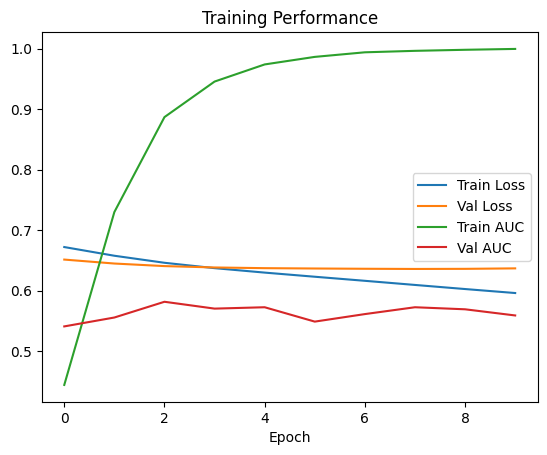

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate, Dot, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow as tf


def process_dense_feats(data, feats):
    data[feats] = data[feats].fillna(0)
    scaler = StandardScaler()
    data[feats] = scaler.fit_transform(data[feats])
    return data


def process_sparse_feats(data, feats):
    label_encoders = {}
    for feat in feats:
        le = LabelEncoder()
        data[feat] = le.fit_transform(data[feat].astype(str))
        label_encoders[feat] = le
    return data, label_encoders


def build_dssm_model(user_feature_dims, item_feature_dims, embedding_dim=8):
    user_inputs = []
    user_embeds = []
    for feat, vocab_size in user_feature_dims.items():
        inp = Input(shape=(1,), name=f"user_{feat}")
        emb = Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim, name=f"user_emb_{feat}")(inp)
        user_inputs.append(inp)
        user_embeds.append(Flatten()(emb))

    item_inputs = []
    item_embeds = []
    for feat, vocab_size in item_feature_dims.items():
        inp = Input(shape=(1,), name=f"item_{feat}")
        emb = Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim, name=f"item_emb_{feat}")(inp)
        item_inputs.append(inp)
        item_embeds.append(Flatten()(emb))

    user_vector = Concatenate()(user_embeds)
    user_vector = Dense(128, activation='relu')(user_vector)
    user_vector = Dense(64, activation='relu')(user_vector)

    item_vector = Concatenate()(item_embeds)
    item_vector = Dense(128, activation='relu')(item_vector)
    item_vector = Dense(64, activation='relu')(item_vector)

    cosine_sim = Lambda(lambda x: K.sum(x[0] * x[1], axis=-1, keepdims=True) / (
        K.sqrt(K.sum(K.square(x[0]), axis=-1, keepdims=True)) * K.sqrt(K.sum(K.square(x[1]), axis=-1, keepdims=True))
        + K.epsilon()))([user_vector, item_vector])

    output = Dense(1, activation='sigmoid')(cosine_sim)

    model = Model(inputs=user_inputs + item_inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model


def load_and_process_data():
    column_names = ["uid", "user_city", "item_id", "author_id", "item_city", "channel", "finish", "like", "music_id", "device", "time", "duration_time", "actors", "genres"]
    data = pd.read_csv(r"D:\\software\\pycharm_repository\\StarMaker\\MultiRecSys\\data_files\\train_2.csv", sep='\t', names=column_names)

    sparse_feats_user = ["uid", "user_city", "device"]
    sparse_feats_item = ["item_id", "author_id", "item_city", "channel", "music_id"]
    dense_feats = ["time", "duration_time"]
    target = 'finish'

    data = process_dense_feats(data, dense_feats)
    data, le_user = process_sparse_feats(data, sparse_feats_user)
    data, le_item = process_sparse_feats(data, sparse_feats_item)

    train, test = train_test_split(data, test_size=0.2, random_state=42)

    user_inputs_train = [train[feat].values for feat in sparse_feats_user]
    item_inputs_train = [train[feat].values for feat in sparse_feats_item]
    user_inputs_test = [test[feat].values for feat in sparse_feats_user]
    item_inputs_test = [test[feat].values for feat in sparse_feats_item]

    user_dims = {feat: data[feat].nunique() for feat in sparse_feats_user}
    item_dims = {feat: data[feat].nunique() for feat in sparse_feats_item}

    return (user_inputs_train, item_inputs_train, train[target].values,
            user_inputs_test, item_inputs_test, test[target].values,
            user_dims, item_dims)


def train_and_evaluate():
    user_inputs_train, item_inputs_train, y_train, user_inputs_test, item_inputs_test, y_test, user_dims, item_dims = load_and_process_data()
    model = build_dssm_model(user_dims, item_dims)
    history = model.fit(user_inputs_train + item_inputs_train, y_train, batch_size=256, epochs=10,
                        validation_split=0.2, verbose=2)
    preds = model.predict(user_inputs_test + item_inputs_test, batch_size=256)
    print("Test LogLoss:", round(log_loss(y_test, preds), 4))
    print("Test AUC:", round(roc_auc_score(y_test, preds), 4))

    # 可视化
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.legend()
    plt.title('Training Performance')
    plt.xlabel('Epoch')
    plt.show()


if __name__ == "__main__":
    train_and_evaluate()


In [3]:
import sys

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from deepctr.feature_column import SparseFeat, VarLenSparseFeat
from tensorflow.python.keras.models import Model
from model.dssm import DSSM
from dssm_preprocess import gen_data_set, gen_model_input, gen_test_inpout
import numpy as np
from tqdm import tqdm
from utils import recall_N
from config.dssm_config import *
import argparse


In [4]:
def parse_args():
    parser = argparse.ArgumentParser(description="DSSM Recommendation System Parameters")

    parser.add_argument("--data_dir", type=str, default=r"D:\software\pycharm_repository\StarMaker\MultiRecSys\data_files\dssm_data_2.csv",help="原始输入数据路径")
    parser.add_argument("--data_final_dir", type=str,default="/data1/guifang.ji/DSSM_SongRecall/data/dssm_data_finash.csv", help="最终处理后的数据路径")

    parser.add_argument("--seq_len", type=int, default=15, help="用户历史序列的最大长度")
    parser.add_argument("--min_count", type=int, default=5, help="商品被点击的最小次数（过滤低频）")
    parser.add_argument("--negsample", type=int, default=3, help="负采样的数量")
    parser.add_argument("--embedding_dim", type=int, default=30, help="Embedding 向量维度")
    parser.add_argument("--batch_size", type=int, default=256, help="训练的批次大小")
    parser.add_argument("--epochs", type=int, default=3, help="训练轮数")
    parser.add_argument("--validation_split", type=float, default=0.0, help="验证集划分比例")
    parser.add_argument("--layer_embeding", type=int, default=32, help="模型中间层嵌入维度")
    parser.add_argument("--pred_topk", type=int, default=200, help="召回预测时选取的 Top-K 数量")
    parser.add_argument("--recall_topk", type=int, default=50, help="评估时的 Top-K 召回覆盖率")

    parser.add_argument("--save_dir", type=str, default="/data1/guifang.ji/DSSM_SongRecall/data/dssm_data_u2i.txt",help="主召回结果保存路径")
    parser.add_argument("--save_dir_new", type=str, default="/data1/guifang.ji/DSSM_SongRecall/data/dssm_data_new.txt",help="新召回结果保存路径")
    parser.add_argument("--save_sdm_dir", type=str, default="/data1/guifang.ji/DSSM_SongRecall/data/sdm_data_u2i.txt",help="SDM 模型召回结果保存路径")
    parser.add_argument("--save_mind_dir", type=str, default="/data1/guifang.ji/DSSM_SongRecall/data/mind_data_u2i.txt",help="MIND 模型召回结果保存路径")
    parser.add_argument("--save_final_dir", type=str,default="/data1/guifang.ji/DSSM_SongRecall/data/dssm_final_u2i.txt", help="最终合并召回结果保存路径")

    # ✅ 关键：让 argparse 忽略 Jupyter 注入的无关参数
    # Jupyter 会自动向 argparse 传入 notebook 的内部参数（比如 -f kernel-xxx.json），而你没有设置接受这些参数，所以报错
    args, _ = parser.parse_known_args()
    return args

args = parse_args()
data_file = args.data_dir
SEQ_LEN = args.seq_len
min_count = args.min_count
negsample = args.negsample
embedding_dim = args.embedding_dim
batch_size = args.batch_size
epoch = args.epochs
validation_split = args.validation_split

user_dnn_hidden_units = user_hidden_unit
item_dnn_hidden_units = item_hidden_unit


In [5]:
# 1.Label Encoding for sparse features,and process sequence features with `gen_date_set` and `gen_model_input`

data = pd.read_csv(data_file, names=data_cloums, sep=',').head(2000)
# print(data.head(5))
# print(data["song_recording_count"])

for header in num_header:
    temp = data[header].fillna(-1)
    data[header] = temp
for header in string_header:
    temp = data[header].fillna("unknow")
    data[header] = temp
for header in time_header:
    temp = data[header].fillna(data[header].min())
    data[header] = temp
# print(data.head())
# print(data["song_recording_count"])

feature_max_idx = {}
encoder = []
for feature in features:
    lbe = LabelEncoder()
    data[feature] = lbe.fit_transform(data[feature]) + 1  # 特征预处理
    feature_max_idx[feature] = data[feature].max() + 1  # 处理后特征的最大值，用来记录特征的数量
    encoder.append(lbe)
# print(encoder)
# print(data[features].head())

user_profile = data[user_fearther].drop_duplicates('user_id')  # 用户特征，drop_duplicates 去重
user_profile.set_index("user_id", inplace=True)  # 将user_id列转为索引，inplace表示在原数据上修改

item_profile = data[item_fearther].drop_duplicates('sm_id')  # 物品特征，去重
item_profile.set_index("sm_id", inplace=True)
# print(item_profile.head())

item_ids = data[["sm_id"]].drop_duplicates('sm_id')
# print(item_ids.head())

train_set, test_set, history_items, hot_ids = gen_data_set(data, min_count, negsample)  # 获取训练集和测试集，训练集和测试集采样方法可修改

1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 7787.54it/s]


In [6]:
# 处理后的特征以字典key: array的结构存储
train_model_input, train_label = gen_model_input(train_set, user_profile, item_profile, SEQ_LEN)
test_user_input, test_item_input, test_label = gen_test_inpout(test_set, user_profile, item_profile, item_ids,
                                                               SEQ_LEN)

# 2.count #unique features for each sparse field and generate feature config for sequence feature
# 特征转化为SparseFeat
user_feature_columns = [SparseFeat('user_id', feature_max_idx['user_id'], embedding_dim),
                        SparseFeat("gender", feature_max_idx['gender'], embedding_dim),
                        SparseFeat("age", feature_max_idx['age'], embedding_dim),
                        SparseFeat("level", feature_max_idx['level'], embedding_dim),
                        SparseFeat("user_lang", feature_max_idx['user_lang'], embedding_dim),
                        SparseFeat("country", feature_max_idx['country'], embedding_dim),
                        SparseFeat("platform", feature_max_idx['platform'], embedding_dim),
                        SparseFeat("is_new", feature_max_idx['is_new'], embedding_dim),
                        VarLenSparseFeat(SparseFeat('hist_sm_id', feature_max_idx['sm_id'], embedding_dim,
                                                    embedding_name="sm_id"), SEQ_LEN, 'mean', 'hist_len'),
                        ]

item_feature_columns = [SparseFeat('sm_id', feature_max_idx['sm_id'], embedding_dim),
                        # SparseFeat("sm_language", feature_max_idx['sm_language'], embedding_dim),
                        SparseFeat("artist_gender", feature_max_idx['artist_gender'], embedding_dim),
                        SparseFeat("song_quality", feature_max_idx['song_quality'], embedding_dim),
                        SparseFeat("song_recording_count", feature_max_idx['song_recording_count'], embedding_dim),
                        SparseFeat("song_genres", feature_max_idx['song_genres'], embedding_dim),
                        ]

In [7]:
# 3.Define Model and train
model = DSSM(user_feature_columns, item_feature_columns, user_dnn_hidden_units=user_dnn_hidden_units,
             item_dnn_hidden_units=item_dnn_hidden_units)

{'user_id': <tensorflow.python.keras.layers.embeddings.Embedding object at 0x000001BE86430A30>, 'gender': <tensorflow.python.keras.layers.embeddings.Embedding object at 0x000001BE864FC160>, 'age': <tensorflow.python.keras.layers.embeddings.Embedding object at 0x000001BE864FC670>, 'level': <tensorflow.python.keras.layers.embeddings.Embedding object at 0x000001BE864FCDC0>, 'user_lang': <tensorflow.python.keras.layers.embeddings.Embedding object at 0x000001BE864FC430>, 'country': <tensorflow.python.keras.layers.embeddings.Embedding object at 0x000001BE865C1100>, 'platform': <tensorflow.python.keras.layers.embeddings.Embedding object at 0x000001BE865C1340>, 'is_new': <tensorflow.python.keras.layers.embeddings.Embedding object at 0x000001BE865C1580>, 'sm_id': <tensorflow.python.keras.layers.embeddings.Embedding object at 0x000001BE865D1220>, 'artist_gender': <tensorflow.python.keras.layers.embeddings.Embedding object at 0x000001BE865C1A00>, 'song_quality': <tensorflow.python.keras.layers.em

In [8]:
model

In [168]:


'''
    StructField("user_id", StringType()),
    StructField("song_id", StringType()),
    StructField("server_timestamp", IntegerType()),
    StructField("user_level", IntegerType()),
    StructField("user_language", StringType()),
    StructField("platform", StringType()),
    # StructField("province", StringType()),
    StructField("country", StringType()),
    StructField("gender", IntegerType()),
    # StructField("song_language", StringType()),
    StructField("artist_gender", IntegerType()),
    StructField("age", IntegerType()),
    StructField("is_new", IntegerType()),
    StructField("song_quality", FloatType()),
    StructField("song_recording_count", IntegerType()),
    StructField("sgenres", StringType())
'''

if __name__ == "__main__":


    # 1.Label Encoding for sparse features,and process sequence features with `gen_date_set` and `gen_model_input`

    data = pd.read_csv(data_file, names=data_cloums, sep=',').head(2000)
    # print(data.head(5))
    # print(data["song_recording_count"])

    for header in num_header:
        temp = data[header].fillna(-1)
        data[header] = temp
    for header in string_header:
        temp = data[header].fillna("unknow")
        data[header] = temp
    for header in time_header:
        temp = data[header].fillna(data[header].min())
        data[header] = temp
    # print(data.head())
    # print(data["song_recording_count"])

    feature_max_idx = {}
    encoder = []
    for feature in features:
        lbe = LabelEncoder()
        data[feature] = lbe.fit_transform(data[feature]) + 1  # 特征预处理
        feature_max_idx[feature] = data[feature].max() + 1  # 处理后特征的最大值，用来记录特征的数量
        encoder.append(lbe)
    # print(encoder)
    # print(data[features].head())

    user_profile = data[user_fearther].drop_duplicates('user_id')  # 用户特征，drop_duplicates 去重
    user_profile.set_index("user_id", inplace=True)  # 将user_id列转为索引，inplace表示在原数据上修改

    item_profile = data[item_fearther].drop_duplicates('sm_id')  # 物品特征，去重
    item_profile.set_index("sm_id", inplace=True)
    # print(item_profile.head())

    item_ids = data[["sm_id"]].drop_duplicates('sm_id')
    # print(item_ids.head())

    train_set, test_set, history_items, hot_ids = gen_data_set(data, min_count, negsample)  # 获取训练集和测试集，训练集和测试集采样方法可修改

    # 处理后的特征以字典key: array的结构存储
    train_model_input, train_label = gen_model_input(train_set, user_profile, item_profile, SEQ_LEN)
    test_user_input, test_item_input, test_label = gen_test_inpout(test_set, user_profile, item_profile, item_ids,
                                                                   SEQ_LEN)

    # 2.count #unique features for each sparse field and generate feature config for sequence feature
    # 特征转化为SparseFeat
    user_feature_columns = [SparseFeat('user_id', feature_max_idx['user_id'], embedding_dim),
                            SparseFeat("gender", feature_max_idx['gender'], embedding_dim),
                            SparseFeat("age", feature_max_idx['age'], embedding_dim),
                            SparseFeat("level", feature_max_idx['level'], embedding_dim),
                            SparseFeat("user_lang", feature_max_idx['user_lang'], embedding_dim),
                            SparseFeat("country", feature_max_idx['country'], embedding_dim),
                            SparseFeat("platform", feature_max_idx['platform'], embedding_dim),
                            SparseFeat("is_new", feature_max_idx['is_new'], embedding_dim),
                            VarLenSparseFeat(SparseFeat('hist_sm_id', feature_max_idx['sm_id'], embedding_dim,
                                                        embedding_name="sm_id"), SEQ_LEN, 'mean', 'hist_len'),
                            ]

    item_feature_columns = [SparseFeat('sm_id', feature_max_idx['sm_id'], embedding_dim),
                            # SparseFeat("sm_language", feature_max_idx['sm_language'], embedding_dim),
                            SparseFeat("artist_gender", feature_max_idx['artist_gender'], embedding_dim),
                            SparseFeat("song_quality", feature_max_idx['song_quality'], embedding_dim),
                            SparseFeat("song_recording_count", feature_max_idx['song_recording_count'], embedding_dim),
                            SparseFeat("song_genres", feature_max_idx['song_genres'], embedding_dim),
                            ]

    # 3.Define Model and train
    model = DSSM(user_feature_columns, item_feature_columns, user_dnn_hidden_units=user_dnn_hidden_units,
                 item_dnn_hidden_units=item_dnn_hidden_units)

    model.compile(optimizer='adagrad', loss="binary_crossentropy")

    history = model.fit(train_model_input, train_label,  # train_label,
                        batch_size=batch_size, epochs=epoch, verbose=1, validation_split=validation_split, )

    # 4. Generate user features for testing and full item features for retrieval
    test_user_model_input = test_user_input
    all_item_model_input = test_item_input

    user_embedding_model = Model(inputs=model.user_input, outputs=model.user_embedding)
    item_embedding_model = Model(inputs=model.item_input, outputs=model.item_embedding)

    user_embs = user_embedding_model.predict(test_user_model_input, batch_size=2 ** 12)
    item_embs = item_embedding_model.predict(all_item_model_input, batch_size=2 ** 12)

    print(user_embs.shape)
    print(item_embs.shape[1])
    user_embs_size = user_embs.shape[1]

    # 5. [Optional] ANN search by faiss  and evaluate the result

    test_true_label = {line[0]: [line[2]] for line in test_set}
    #


    import faiss
    index = faiss.IndexFlatIP(user_embs_size)
    # faiss.normalize_L2(item_embs)
    index.add(item_embs)
    # faiss.normalize_L2(user_embs)
    D, I = index.search(user_embs, FLAGS.pred_topk)

    hot_10 = []
    hot_50 = []
    hot_hit = 0
    hot_count = 0
    recall_50 = []
    recall_10 = []
    hit = 0
    print(len(test_user_model_input['user_id']))
    print(item_ids['sm_id'].values[I[0][0]])
    # f = open(FLAGS.save_dir, 'w')

    c_top100 = 0
    for i, uid in tqdm(enumerate(test_user_model_input['user_id'])):
        try:
            pred = [item_ids['sm_id'].values[x] for x in I[i]]
            #print(1)
            filter_item = None
            rec_10 = recall_N(test_true_label[uid], pred, N=10)
            rec_50 = recall_N(test_true_label[uid], pred, N=FLAGS.recall_topk)
            # print(2)

            # recall_10.append(rec_10)
            # recall_50.append(rec_50)
            # if test_true_label[uid] in pred:
            #    hit += 1

            for lab in test_true_label[uid]:
                if lab in hot_ids:
                    hot_10.append(rec_10)
                    hot_50.append(rec_50)
                    hot_count += 1
                else:
                    recall_10.append(rec_10)
                    recall_50.append(rec_50)
            # print(1)
            for lab in test_true_label[uid]:
                if lab in pred:
                    if lab in hot_ids:
                        hot_hit += 1
                    else:
                        hit += 1
            '''
            his_item = set(history_items[uid])
            pred = [item_ids['sm_id'].values[x] - 1 for x in I[i] if item_ids['sm_id'].values[x] not in his_item]
            if len(pred) < 100:
                c_top100 += 1
            user_orgin = encoder[0].inverse_transform([uid - 1])   # 特征处理之前的uid
            item_orgin = [str(x) for x in encoder[1].inverse_transform(pred)]    # 特征处理之前的item_id
            f.write(str(user_orgin[0]) + "\t" + ','.join(item_orgin) + '\n')
            # break
            '''
        except Exception as e:
            print(i, e)
            continue
            # break
    # f.close()

    print("hot_10", np.mean(hot_10))
    print("hot_50", np.mean(hot_50))
    print("hr", hit / max(1, hot_count))
    print(hot_count)

    print("recall_10", np.mean(recall_10))
    print("recall_50", np.mean(recall_50))
    print("hr", hit / len(test_user_model_input['user_id']))
    print("pret less 100: ", c_top100)






D:\software\pycharm_repository\StarMaker\MultiRecSys\recall\DSSM_SongRecall\dssm_preprocess.py:15: RuntimeWarning: divide by zero encountered in longlong_scalars
  # hot_ids = item_ids.loc[item_ids['num'] > int(item_ids["num"].sum() / (int(item_ids.shape[0] * 0.1)))]


OverflowError: cannot convert float infinity to integer

In [86]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from deepctr.feature_column import SparseFeat, VarLenSparseFeat
from tensorflow.python.keras.models import Model
from dssm_preprocess import gen_data_set, gen_model_input, gen_test_inpout
import numpy as np
from tqdm import tqdm
import argparse
from config.dssm_config import *

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from deepctr.feature_column import SparseFeat, VarLenSparseFeat
from tensorflow.python.keras.models import Model
from model.dssm import DSSM
from dssm_preprocess import gen_data_set, gen_model_input, gen_test_inpout
import numpy as np
from tqdm import tqdm
from utils import recall_N
from config.dssm_config import *

In [87]:
def parse_args():
    parser = argparse.ArgumentParser(description="DSSM Recommendation System Parameters")

    parser.add_argument("--data_dir", type=str, default=r"D:\software\pycharm_repository\StarMaker\MultiRecSys\data_files\dssm_data_2.csv",help="原始输入数据路径")
    parser.add_argument("--data_final_dir", type=str,default="/data1/guifang.ji/DSSM_SongRecall/data/dssm_data_finash.csv", help="最终处理后的数据路径")

    parser.add_argument("--seq_len", type=int, default=15, help="用户历史序列的最大长度")
    parser.add_argument("--min_count", type=int, default=5, help="商品被点击的最小次数（过滤低频）")
    parser.add_argument("--negsample", type=int, default=3, help="负采样的数量")
    parser.add_argument("--embedding_dim", type=int, default=30, help="Embedding 向量维度")
    parser.add_argument("--batch_size", type=int, default=256, help="训练的批次大小")
    parser.add_argument("--epochs", type=int, default=3, help="训练轮数")
    parser.add_argument("--validation_split", type=float, default=0.0, help="验证集划分比例")
    parser.add_argument("--layer_embeding", type=int, default=32, help="模型中间层嵌入维度")
    parser.add_argument("--pred_topk", type=int, default=200, help="召回预测时选取的 Top-K 数量")
    parser.add_argument("--recall_topk", type=int, default=50, help="评估时的 Top-K 召回覆盖率")

    parser.add_argument("--save_dir", type=str, default="/data1/guifang.ji/DSSM_SongRecall/data/dssm_data_u2i.txt",help="主召回结果保存路径")
    parser.add_argument("--save_dir_new", type=str, default="/data1/guifang.ji/DSSM_SongRecall/data/dssm_data_new.txt",help="新召回结果保存路径")
    parser.add_argument("--save_sdm_dir", type=str, default="/data1/guifang.ji/DSSM_SongRecall/data/sdm_data_u2i.txt",help="SDM 模型召回结果保存路径")
    parser.add_argument("--save_mind_dir", type=str, default="/data1/guifang.ji/DSSM_SongRecall/data/mind_data_u2i.txt",help="MIND 模型召回结果保存路径")
    parser.add_argument("--save_final_dir", type=str,default="/data1/guifang.ji/DSSM_SongRecall/data/dssm_final_u2i.txt", help="最终合并召回结果保存路径")

    # ✅ 关键：让 argparse 忽略 Jupyter 注入的无关参数
    # Jupyter 会自动向 argparse 传入 notebook 的内部参数（比如 -f kernel-xxx.json），而你没有设置接受这些参数，所以报错
    args, _ = parser.parse_known_args()
    return args

args = parse_args()
data_file = args.data_dir
SEQ_LEN = args.seq_len
min_count = args.min_count
negsample = args.negsample
embedding_dim = args.embedding_dim
batch_size = args.batch_size
epoch = args.epochs
validation_split = args.validation_split

user_dnn_hidden_units = user_hidden_unit
item_dnn_hidden_units = item_hidden_unit


In [90]:
print("训练数据路径：", args.data_dir)

训练数据路径： D:\software\pycharm_repository\StarMaker\MultiRecSys\data_files\dssm_data_2.csv


In [91]:
data_cloums

['user_id',
 'sm_id',
 'timestamp',
 'level',
 'user_lang',
 'platform',
 'country',
 'gender',
 'age',
 'song_lang_id',
 'artist_gender',
 'song_quality',
 'song_recording_count',
 'song_genres',
 'song_create_time',
 'artist_country_id',
 'region',
 'is_new']

In [92]:
data = pd.read_csv(data_file, names=data_cloums, sep=',').head(1000)

In [93]:
data

,user_id,sm_id,timestamp,level,user_lang,platform,country,gender,age,song_lang_id,artist_gender,song_quality,song_recording_count,song_genres,song_create_time,artist_country_id,region,is_new
0,60456,611720463661,1672671210,5,hi,android,IN,1,0,11,1,1000.0,8989,NaN,1584604060,6,IN,0
1,60456,611024198908,1672691614,1,pt,android,BR,0,0,27,4,1000.0,42536,NaN,1634263591,215,BR,1
2,60456,611020836603,1672650725,3,hi,android,IN,2,4,11,1,1000.0,5194,NaN,1591585397,6,IN,0
3,60456,611024677061,1672697682,5,en,android,SA,2,0,2,2,1000.0,61038,NaN,1641524422,3,ME,0
4,60456,611718910963,1672701264,4,id,android,ID,2,5,23,1,1000.0,14252,Electronic,1511923985,79,ID,0
5,8426356,611021225275,1672671401,1,bn,android,BD,0,0,31,1,1000.0,3145,NaN,1592556657,91,BD,1
6,8426356,611755071229,1672660062,5,en,android,PH,2,0,2,2,1000.0,145452,NaN,1487232401,4,PH,0
7,8426356,611715621284,1672640270,3,tl,android,PH,1,0,2,1,1000.0,47748,Jazz,1492149188,2,PH,0
8,8426356,611720547780,1672661630,4,hi,android,IN,2,4,11,1,1000.0,3353,NaN,1587988984,6,IN,0
9,8426356,611719222892,1672654799,5,es,android,VE,1,0,25,1,1000.0,1285,Latin,1516679701,104,CO,0


In [94]:
# 查看 song_genres 列的所有不同种类
unique_genres = data["song_genres"].unique()
print(unique_genres)

[nan 'Electronic' 'Jazz' 'Latin']


In [95]:
data.describe()

,user_id,sm_id,timestamp,level,gender,age,song_lang_id,artist_gender,song_quality,song_recording_count,song_create_time,artist_country_id,is_new
count,1.000000e+01,1.000000e+01,1.000000e+01,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,1.000000e+01,10.000000,10.000000
mean,4.243406e+06,6.114441e+11,1.672670e+09,3.600000,1.300000,1.300000,14.500000,1.500000,1000.0,33299.200000,1.564051e+09,51.600000,0.200000
std,4.409216e+06,3.628052e+08,2.073529e+04,1.577621,0.823273,2.110819,11.138023,0.971825,0.0,44989.407965,5.728132e+07,70.769108,0.421637
min,6.045600e+04,6.110208e+11,1.672640e+09,1.000000,0.000000,0.000000,2.000000,1.000000,1000.0,1285.000000,1.487232e+09,2.000000,0.000000
25%,6.045600e+04,6.110243e+11,1.672656e+09,3.000000,1.000000,0.000000,4.250000,1.000000,1000.0,3813.250000,1.513113e+09,4.500000,0.000000
50%,4.243406e+06,6.117173e+11,1.672666e+09,4.000000,1.500000,0.000000,11.000000,1.000000,1000.0,11620.500000,1.586297e+09,6.000000,0.000000
75%,8.426356e+06,6.117202e+11,1.672687e+09,5.000000,2.000000,3.000000,24.500000,1.750000,1000.0,46445.000000,1.592314e+09,88.000000,0.000000
max,8.426356e+06,6.117551e+11,1.672701e+09,5.000000,2.000000,5.000000,31.000000,4.000000,1000.0,145452.000000,1.641524e+09,215.000000,1.000000


In [96]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               10 non-null     int64  
 1   sm_id                 10 non-null     int64  
 2   timestamp             10 non-null     int64  
 3   level                 10 non-null     int64  
 4   user_lang             10 non-null     object 
 5   platform              10 non-null     object 
 6   country               10 non-null     object 
 7   gender                10 non-null     int64  
 8   age                   10 non-null     int64  
 9   song_lang_id          10 non-null     int64  
 10  artist_gender         10 non-null     int64  
 11  song_quality          10 non-null     float64
 12  song_recording_count  10 non-null     int64  
 13  song_genres           3 non-null      object 
 14  song_create_time      10 non-null     int64  
 15  artist_country_id     10 n

In [97]:
num_header

['level',
 'gender',
 'age',
 'artist_gender',
 'is_new',
 'song_quality',
 'song_recording_count']

In [98]:
string_header

['user_id', 'sm_id', 'user_lang', 'platform', 'country', 'song_genres']

In [99]:
time_header

['timestamp']

In [100]:
# 对数值型字段进行缺失值填充，将 NaN 填为 -1（表示无效值或缺失）
for header in num_header:
    temp = data[header].fillna(-1)  # 用 -1 替换空值
    data[header] = temp             # 将填充后的列重新赋值回原始数据

# 对字符串型字段进行缺失值填充，将 NaN 填为 "unknow"（表示未知类别）
for header in string_header:
    temp = data[header].fillna("unknow")  # 用字符串 "unknow" 替换空值
    data[header] = temp                   # 更新原始数据中的对应列

# 对时间型字段进行缺失值填充，用该列的最小值填充（表示最早时间）
for header in time_header:
    temp = data[header].fillna(data[header].min())  # 用该列最小时间替换空值
    data[header] = temp                             # 更新原始数据中的对应列

In [101]:
data

,user_id,sm_id,timestamp,level,user_lang,platform,country,gender,age,song_lang_id,artist_gender,song_quality,song_recording_count,song_genres,song_create_time,artist_country_id,region,is_new
0,60456,611720463661,1672671210,5,hi,android,IN,1,0,11,1,1000.0,8989,unknow,1584604060,6,IN,0
1,60456,611024198908,1672691614,1,pt,android,BR,0,0,27,4,1000.0,42536,unknow,1634263591,215,BR,1
2,60456,611020836603,1672650725,3,hi,android,IN,2,4,11,1,1000.0,5194,unknow,1591585397,6,IN,0
3,60456,611024677061,1672697682,5,en,android,SA,2,0,2,2,1000.0,61038,unknow,1641524422,3,ME,0
4,60456,611718910963,1672701264,4,id,android,ID,2,5,23,1,1000.0,14252,Electronic,1511923985,79,ID,0
5,8426356,611021225275,1672671401,1,bn,android,BD,0,0,31,1,1000.0,3145,unknow,1592556657,91,BD,1
6,8426356,611755071229,1672660062,5,en,android,PH,2,0,2,2,1000.0,145452,unknow,1487232401,4,PH,0
7,8426356,611715621284,1672640270,3,tl,android,PH,1,0,2,1,1000.0,47748,Jazz,1492149188,2,PH,0
8,8426356,611720547780,1672661630,4,hi,android,IN,2,4,11,1,1000.0,3353,unknow,1587988984,6,IN,0
9,8426356,611719222892,1672654799,5,es,android,VE,1,0,25,1,1000.0,1285,Latin,1516679701,104,CO,0


In [102]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               10 non-null     int64  
 1   sm_id                 10 non-null     int64  
 2   timestamp             10 non-null     int64  
 3   level                 10 non-null     int64  
 4   user_lang             10 non-null     object 
 5   platform              10 non-null     object 
 6   country               10 non-null     object 
 7   gender                10 non-null     int64  
 8   age                   10 non-null     int64  
 9   song_lang_id          10 non-null     int64  
 10  artist_gender         10 non-null     int64  
 11  song_quality          10 non-null     float64
 12  song_recording_count  10 non-null     int64  
 13  song_genres           10 non-null     object 
 14  song_create_time      10 non-null     int64  
 15  artist_country_id     10 n

In [103]:
features

['user_id',
 'sm_id',
 'level',
 'user_lang',
 'platform',
 'country',
 'gender',
 'artist_gender',
 'age',
 'is_new',
 'song_quality',
 'song_recording_count',
 'song_genres']

LabelEncoder 专门用来把离散特征（分类特征）转成整数型 ID，为后续建模做准备

In [104]:
# 初始化一个空字典，用于保存每个特征编码后的最大值（特征类别数 + 1）
feature_max_idx = {}

# 初始化一个空列表，用于保存每个特征对应的 LabelEncoder 对象
encoder = []

# 遍历所有需要编码的特征字段
for feature in features:
    lbe = LabelEncoder()  # 创建一个新的 LabelEncoder 实例，用来处理当前特征
    
    # 对当前特征进行编码，将类别型特征转为整数索引，并整体加1（避免0与padding混淆）
    data[feature] = lbe.fit_transform(data[feature]) + 1
    
    # 记录当前特征的最大编码值（用于后续 Embedding 层的input_dim设置）
    feature_max_idx[feature] = data[feature].max() + 1
    
    # 将当前特征对应的 LabelEncoder 保存下来，供后续反编码或推理时使用
    encoder.append(lbe)

In [105]:
feature_max_idx

{'user_id': 3,
 'sm_id': 11,
 'level': 5,
 'user_lang': 8,
 'platform': 2,
 'country': 8,
 'gender': 4,
 'artist_gender': 4,
 'age': 4,
 'is_new': 3,
 'song_quality': 2,
 'song_recording_count': 11,
 'song_genres': 5}

In [106]:
encoder

[LabelEncoder(),
 LabelEncoder(),
 LabelEncoder(),
 LabelEncoder(),
 LabelEncoder(),
 LabelEncoder(),
 LabelEncoder(),
 LabelEncoder(),
 LabelEncoder(),
 LabelEncoder(),
 LabelEncoder(),
 LabelEncoder(),
 LabelEncoder()]

In [107]:
data

,user_id,sm_id,timestamp,level,user_lang,platform,country,gender,age,song_lang_id,artist_gender,song_quality,song_recording_count,song_genres,song_create_time,artist_country_id,region,is_new
0,1,8,1672671210,4,4,1,4,2,1,11,1,1,5,4,1584604060,6,IN,1
1,1,3,1672691614,1,6,1,2,1,1,27,3,1,7,4,1634263591,215,BR,2
2,1,1,1672650725,2,4,1,4,3,2,11,1,1,4,4,1591585397,6,IN,1
3,1,4,1672697682,4,2,1,6,3,1,2,2,1,9,4,1641524422,3,ME,1
4,1,6,1672701264,3,5,1,3,3,3,23,1,1,6,1,1511923985,79,ID,1
5,2,2,1672671401,1,1,1,1,1,1,31,1,1,2,4,1592556657,91,BD,2
6,2,10,1672660062,4,2,1,5,3,1,2,2,1,10,4,1487232401,4,PH,1
7,2,5,1672640270,2,7,1,5,2,1,2,1,1,8,2,1492149188,2,PH,1
8,2,9,1672661630,3,4,1,4,3,2,11,1,1,3,4,1587988984,6,IN,1
9,2,7,1672654799,4,3,1,7,2,1,25,1,1,1,3,1516679701,104,CO,1


In [108]:
user_fearther

['user_id',
 'gender',
 'age',
 'level',
 'user_lang',
 'country',
 'platform',
 'is_new']

In [109]:
user_fearther

['user_id',
 'gender',
 'age',
 'level',
 'user_lang',
 'country',
 'platform',
 'is_new']

In [110]:
# 从原始数据中提取用户相关特征字段，并按 user_id 去重，只保留每个用户的一条记录，生成用户画像表
user_profile = data[user_fearther].drop_duplicates('user_id')

In [111]:
user_profile

,user_id,gender,age,level,user_lang,country,platform,is_new
0,1,2,1,4,4,4,1,1
5,2,1,1,1,1,1,1,2


In [112]:
# 将 user_profile 表中的 user_id 列设置为索引，使后续可以通过 user_id 快速查找用户特征；
# inplace=True 表示在原 DataFrame 上直接修改，不返回新的副本。
user_profile.set_index("user_id", inplace=True)

In [113]:
# user_id 会从 DataFrame 中移到索引上，不再是普通的一列了
user_profile

,gender,age,level,user_lang,country,platform,is_new
user_id,,,,,,,
1,2,1,4,4,4,1,1
2,1,1,1,1,1,1,2


In [114]:
# 从原始数据中提取物品相关的特征字段，并按 sm_id 去重，只保留每个物品的一条记录
item_profile = data[item_fearther].drop_duplicates('sm_id')

# 将 item_profile 表中的 sm_id 列设置为索引，方便后续通过 sm_id 快速查找物品特征
# inplace=True 表示直接在原 DataFrame 上修改，不返回新的副本
item_profile.set_index("sm_id", inplace=True)

In [115]:
item_profile

,artist_gender,song_quality,song_recording_count,song_genres
sm_id,,,,
8,1,1,5,4
3,3,1,7,4
1,1,1,4,4
4,2,1,9,4
6,1,1,6,1
2,1,1,2,4
10,2,1,10,4
5,1,1,8,2
9,1,1,3,4


In [116]:
item_ids = data[["sm_id"]].drop_duplicates('sm_id')

In [117]:
item_ids

,sm_id
0,8
1,3
2,1
3,4
4,6
5,2
6,10
7,5
8,9
9,7


In [118]:
data

,user_id,sm_id,timestamp,level,user_lang,platform,country,gender,age,song_lang_id,artist_gender,song_quality,song_recording_count,song_genres,song_create_time,artist_country_id,region,is_new
0,1,8,1672671210,4,4,1,4,2,1,11,1,1,5,4,1584604060,6,IN,1
1,1,3,1672691614,1,6,1,2,1,1,27,3,1,7,4,1634263591,215,BR,2
2,1,1,1672650725,2,4,1,4,3,2,11,1,1,4,4,1591585397,6,IN,1
3,1,4,1672697682,4,2,1,6,3,1,2,2,1,9,4,1641524422,3,ME,1
4,1,6,1672701264,3,5,1,3,3,3,23,1,1,6,1,1511923985,79,ID,1
5,2,2,1672671401,1,1,1,1,1,1,31,1,1,2,4,1592556657,91,BD,2
6,2,10,1672660062,4,2,1,5,3,1,2,2,1,10,4,1487232401,4,PH,1
7,2,5,1672640270,2,7,1,5,2,1,2,1,1,8,2,1492149188,2,PH,1
8,2,9,1672661630,3,4,1,4,3,2,11,1,1,3,4,1587988984,6,IN,1
9,2,7,1672654799,4,3,1,7,2,1,25,1,1,1,3,1516679701,104,CO,1


In [119]:
min_count

5

In [5]:
for i in range(1, 1):
    print(i)

In [120]:
negsample

3

In [121]:
# parser.add_argument("--min_count", type=int, default=5, help="商品被点击的最小次数（过滤低频）")
# parser.add_argument("--negsample", type=int, default=3, help="负采样的数量")

In [122]:
# 假设：

#     min_count=5

#     negsample=3

# 数据处理流程是：

#     先把那些点击次数小于 5 次的商品删掉；

#     每个用户的正样本（用户点过的商品）保留下来；

#     对每个正样本，随机找 3 个用户没有点过的商品作为负样本；

#     最后组成训练数据（正样本 + 负样本一起训练）。

In [123]:
def gen_data_set(data, min_count, negsample=0):
    data.sort_values("timestamp", inplace=True)
    item_ids = data[['sm_id']]
    # 统计sm_id 出现的次数, 转为dataframe
    item_ids = item_ids['sm_id'].value_counts().rename_axis('sm_id').reset_index(name='num')
#     item_ids = item_ids.loc[item_ids['num'] > min_count]

    hot_ids = item_ids.loc[item_ids['num'] > int(item_ids["num"].sum() / (int(item_ids.shape[0] * 0.1)))]
    hot_ids = set(hot_ids['sm_id'].unique())

    item_nums = item_ids['num'].to_list()  # .div(item_ids['num'].sum())
    item_ids = item_ids['sm_id'].unique()

    train_set = []
    test_set = []
    count = 0
    user_items = {}
    print(1)
    print(data.groupby('user_id'))
    for reviewerID, hist in tqdm(data.groupby('user_id')):
        # print(reviewerID, hist)
        pos_list = hist['sm_id'].tolist()  # 用户浏览过的item_id
        pos_list = pos_list[:min(100, len(pos_list))]
        user_items[reviewerID] = pos_list
        neg_list = set()
        if negsample > 0:  # 全局负采样
            candidate_set = list(set(item_ids) - set(pos_list))
            neg_list = np.random.choice(candidate_set, size=len(pos_list) * negsample, replace=True)

        for i in range(1, len(pos_list)):
            hist = pos_list[:i]
            if i != len(pos_list) - 1:
                # 用户ID + 浏览记录倒排 + 当前itemID + 正负样本label（1，0） + 浏览记录的长度 + item评分（正样本有，负样本没有）
                train_set.append((reviewerID, hist[::-1], pos_list[i], 1, len(hist[::-1]), 1))
                for negi in range(negsample):
                    train_set.append((reviewerID, hist[::-1], neg_list[i * negsample + negi], 0, len(hist[::-1])))
            else:
                test_set.append((reviewerID, hist[::-1], pos_list[i], 1, len(hist[::-1]), 1))
        count += 1
    # 打散
#     random.shuffle(train_set)
#     random.shuffle(test_set)

    return train_set, test_set, user_items, hot_ids

In [124]:
data

,user_id,sm_id,timestamp,level,user_lang,platform,country,gender,age,song_lang_id,artist_gender,song_quality,song_recording_count,song_genres,song_create_time,artist_country_id,region,is_new
0,1,8,1672671210,4,4,1,4,2,1,11,1,1,5,4,1584604060,6,IN,1
1,1,3,1672691614,1,6,1,2,1,1,27,3,1,7,4,1634263591,215,BR,2
2,1,1,1672650725,2,4,1,4,3,2,11,1,1,4,4,1591585397,6,IN,1
3,1,4,1672697682,4,2,1,6,3,1,2,2,1,9,4,1641524422,3,ME,1
4,1,6,1672701264,3,5,1,3,3,3,23,1,1,6,1,1511923985,79,ID,1
5,2,2,1672671401,1,1,1,1,1,1,31,1,1,2,4,1592556657,91,BD,2
6,2,10,1672660062,4,2,1,5,3,1,2,2,1,10,4,1487232401,4,PH,1
7,2,5,1672640270,2,7,1,5,2,1,2,1,1,8,2,1492149188,2,PH,1
8,2,9,1672661630,3,4,1,4,3,2,11,1,1,3,4,1587988984,6,IN,1
9,2,7,1672654799,4,3,1,7,2,1,25,1,1,1,3,1516679701,104,CO,1


In [125]:
train_set, test_set, history_items, hot_ids = gen_data_set(data, min_count, negsample)  # 获取训练集和测试集，训练集和测试集采样方法可修改

1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1271.39it/s]


In [126]:
train_set
# 用户ID + 浏览记录倒排 + 当前itemID + 正负样本label（1，0） + 浏览记录的长度 + item评分（正样本有，负样本没有）

[(1, [1], 8, 1, 1, 1),
 (1, [1], 10, 0, 1),
 (1, [1], 5, 0, 1),
 (1, [1], 10, 0, 1),
 (1, [8, 1], 3, 1, 2, 1),
 (1, [8, 1], 10, 0, 2),
 (1, [8, 1], 10, 0, 2),
 (1, [8, 1], 2, 0, 2),
 (1, [3, 8, 1], 4, 1, 3, 1),
 (1, [3, 8, 1], 2, 0, 3),
 (1, [3, 8, 1], 2, 0, 3),
 (1, [3, 8, 1], 5, 0, 3),
 (2, [5], 7, 1, 1, 1),
 (2, [5], 8, 0, 1),
 (2, [5], 3, 0, 1),
 (2, [5], 8, 0, 1),
 (2, [7, 5], 10, 1, 2, 1),
 (2, [7, 5], 3, 0, 2),
 (2, [7, 5], 6, 0, 2),
 (2, [7, 5], 4, 0, 2),
 (2, [10, 7, 5], 9, 1, 3, 1),
 (2, [10, 7, 5], 4, 0, 3),
 (2, [10, 7, 5], 4, 0, 3),
 (2, [10, 7, 5], 4, 0, 3)]

In [127]:
import random
import numpy as np
from tqdm import tqdm

In [128]:
test_set

[(1, [4, 3, 8, 1], 6, 1, 4, 1), (2, [9, 10, 7, 5], 2, 1, 4, 1)]

In [129]:
history_items

{1: [1, 8, 3, 4, 6], 2: [5, 7, 10, 9, 2]}

In [130]:
hot_ids

set()

In [131]:
train_set

[(1, [1], 8, 1, 1, 1),
 (1, [1], 10, 0, 1),
 (1, [1], 5, 0, 1),
 (1, [1], 10, 0, 1),
 (1, [8, 1], 3, 1, 2, 1),
 (1, [8, 1], 10, 0, 2),
 (1, [8, 1], 10, 0, 2),
 (1, [8, 1], 2, 0, 2),
 (1, [3, 8, 1], 4, 1, 3, 1),
 (1, [3, 8, 1], 2, 0, 3),
 (1, [3, 8, 1], 2, 0, 3),
 (1, [3, 8, 1], 5, 0, 3),
 (2, [5], 7, 1, 1, 1),
 (2, [5], 8, 0, 1),
 (2, [5], 3, 0, 1),
 (2, [5], 8, 0, 1),
 (2, [7, 5], 10, 1, 2, 1),
 (2, [7, 5], 3, 0, 2),
 (2, [7, 5], 6, 0, 2),
 (2, [7, 5], 4, 0, 2),
 (2, [10, 7, 5], 9, 1, 3, 1),
 (2, [10, 7, 5], 4, 0, 3),
 (2, [10, 7, 5], 4, 0, 3),
 (2, [10, 7, 5], 4, 0, 3)]

In [132]:
user_profile

,gender,age,level,user_lang,country,platform,is_new
user_id,,,,,,,
1,2,1,4,4,4,1,1
2,1,1,1,1,1,1,2


In [133]:
item_profile

,artist_gender,song_quality,song_recording_count,song_genres
sm_id,,,,
8,1,1,5,4
3,3,1,7,4
1,1,1,4,4
4,2,1,9,4
6,1,1,6,1
2,1,1,2,4
10,2,1,10,4
5,1,1,8,2
9,1,1,3,4


In [134]:
SEQ_LEN

15

In [135]:
# 处理后的特征以字典key: array的结构存储
train_model_input, train_label = gen_model_input(train_set, user_profile, item_profile, SEQ_LEN)

In [136]:
type(train_model_input)

dict

In [137]:
train_model_input

{'user_id': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2]),
 'sm_id': array([ 8, 10,  5, 10,  3, 10, 10,  2,  4,  2,  2,  5,  7,  8,  3,  8, 10,
         3,  6,  4,  9,  4,  4,  4], dtype=int64),
 'hist_sm_id': array([[ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 8,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 8,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 8,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 8,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 3,  8,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 3,  8,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 3,  8,  1,  0,  0,  0,  0,  0,  0,  0, 

In [138]:
train_label

array([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0])

In [139]:
train_model_input

{'user_id': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2]),
 'sm_id': array([ 8, 10,  5, 10,  3, 10, 10,  2,  4,  2,  2,  5,  7,  8,  3,  8, 10,
         3,  6,  4,  9,  4,  4,  4], dtype=int64),
 'hist_sm_id': array([[ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 8,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 8,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 8,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 8,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 3,  8,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 3,  8,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 3,  8,  1,  0,  0,  0,  0,  0,  0,  0, 

In [140]:
import pandas as pd

# 深拷贝字典，以免影响原始数据
train_model_input_flat = train_model_input.copy()

# 将二维列表类型的字段（如 hist_sm_id）转为字符串形式展示
if 'hist_sm_id' in train_model_input_flat:
    train_model_input_flat['hist_sm_id'] = [
        ','.join(map(str, seq)) if isinstance(seq, (list, tuple)) else str(seq)
        for seq in train_model_input_flat['hist_sm_id']
    ]

# 创建 DataFrame
df = pd.DataFrame(train_model_input_flat)

# 显示前几行
df.head()

,user_id,sm_id,hist_sm_id,hist_len,gender,age,level,user_lang,country,platform,is_new,artist_gender,song_quality,song_recording_count,song_genres
0,1,8,[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0],1,2,1,4,4,4,1,1,1,1,5,4
1,1,10,[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0],1,2,1,4,4,4,1,1,2,1,10,4
2,1,5,[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0],1,2,1,4,4,4,1,1,1,1,8,2
3,1,10,[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0],1,2,1,4,4,4,1,1,2,1,10,4
4,1,3,[8 1 0 0 0 0 0 0 0 0 0 0 0 0 0],2,2,1,4,4,4,1,1,3,1,7,4


In [141]:
train_set

[(1, [1], 8, 1, 1, 1),
 (1, [1], 10, 0, 1),
 (1, [1], 5, 0, 1),
 (1, [1], 10, 0, 1),
 (1, [8, 1], 3, 1, 2, 1),
 (1, [8, 1], 10, 0, 2),
 (1, [8, 1], 10, 0, 2),
 (1, [8, 1], 2, 0, 2),
 (1, [3, 8, 1], 4, 1, 3, 1),
 (1, [3, 8, 1], 2, 0, 3),
 (1, [3, 8, 1], 2, 0, 3),
 (1, [3, 8, 1], 5, 0, 3),
 (2, [5], 7, 1, 1, 1),
 (2, [5], 8, 0, 1),
 (2, [5], 3, 0, 1),
 (2, [5], 8, 0, 1),
 (2, [7, 5], 10, 1, 2, 1),
 (2, [7, 5], 3, 0, 2),
 (2, [7, 5], 6, 0, 2),
 (2, [7, 5], 4, 0, 2),
 (2, [10, 7, 5], 9, 1, 3, 1),
 (2, [10, 7, 5], 4, 0, 3),
 (2, [10, 7, 5], 4, 0, 3),
 (2, [10, 7, 5], 4, 0, 3)]

In [142]:
train_label

array([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0])

In [143]:
item_profile

,artist_gender,song_quality,song_recording_count,song_genres
sm_id,,,,
8,1,1,5,4
3,3,1,7,4
1,1,1,4,4
4,2,1,9,4
6,1,1,6,1
2,1,1,2,4
10,2,1,10,4
5,1,1,8,2
9,1,1,3,4


In [144]:
test_set

[(1, [4, 3, 8, 1], 6, 1, 4, 1), (2, [9, 10, 7, 5], 2, 1, 4, 1)]

In [145]:
item_ids

,sm_id
0,8
1,3
2,1
3,4
4,6
5,2
6,10
7,5
8,9
9,7


In [146]:
test_user_input, test_item_input, test_label = gen_test_inpout(test_set, user_profile, item_profile, item_ids,SEQ_LEN)

In [147]:
test_user_input

{'user_id': array([1, 2]),
 'hist_sm_id': array([[ 4,  3,  8,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 9, 10,  7,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]),
 'hist_len': array([4, 4]),
 'gender': array([2, 1], dtype=int64),
 'age': array([1, 1], dtype=int64),
 'level': array([4, 1], dtype=int64),
 'user_lang': array([4, 1]),
 'country': array([4, 1]),
 'platform': array([1, 1]),
 'is_new': array([1, 2], dtype=int64)}

In [148]:
import pandas as pd

# 深拷贝字典，以免影响原始数据
train_model_input_flat = test_user_input.copy()

# 将二维列表类型的字段（如 hist_sm_id）转为字符串形式展示
if 'hist_sm_id' in train_model_input_flat:
    train_model_input_flat['hist_sm_id'] = [
        ','.join(map(str, seq)) if isinstance(seq, (list, tuple)) else str(seq)
        for seq in train_model_input_flat['hist_sm_id']
    ]

# 创建 DataFrame
df = pd.DataFrame(train_model_input_flat)

# 显示前几行
df.head()

,user_id,hist_sm_id,hist_len,gender,age,level,user_lang,country,platform,is_new
0,1,[4 3 8 1 0 0 0 0 0 0 0 0 0 0 0],4,2,1,4,4,4,1,1
1,2,[ 9 10 7 5 0 0 0 0 0 0 0 0 0 0 0],4,1,1,1,1,1,1,2


In [149]:
test_item_input

{'sm_id': array([ 8,  3,  1,  4,  6,  2, 10,  5,  9,  7], dtype=int64),
 'artist_gender': array([1, 3, 1, 2, 1, 1, 2, 1, 1, 1], dtype=int64),
 'song_quality': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64),
 'song_recording_count': array([ 5,  7,  4,  9,  6,  2, 10,  8,  3,  1], dtype=int64),
 'song_genres': array([4, 4, 4, 4, 1, 4, 4, 2, 4, 3])}

In [150]:
test_label

array([1, 1])

In [151]:
# 2.count #unique features for each sparse field and generate feature config for sequence feature
# 特征转化为SparseFeat
user_feature_columns = [SparseFeat('user_id', feature_max_idx['user_id'], embedding_dim),
                        SparseFeat("gender", feature_max_idx['gender'], embedding_dim),
                        SparseFeat("age", feature_max_idx['age'], embedding_dim),
                        SparseFeat("level", feature_max_idx['level'], embedding_dim),
                        SparseFeat("user_lang", feature_max_idx['user_lang'], embedding_dim),
                        SparseFeat("country", feature_max_idx['country'], embedding_dim),
                        SparseFeat("platform", feature_max_idx['platform'], embedding_dim),
                        SparseFeat("is_new", feature_max_idx['is_new'], embedding_dim),
                        VarLenSparseFeat(SparseFeat('hist_sm_id', feature_max_idx['sm_id'], embedding_dim,
                                                    embedding_name="sm_id"), SEQ_LEN, 'mean', 'hist_len'),
                        ]

In [152]:
user_feature_columns

[SparseFeat(name='user_id', vocabulary_size=3, embedding_dim=30, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x0000024186707AC0>, embedding_name='user_id', group_name='default_group', trainable=True),
 SparseFeat(name='gender', vocabulary_size=4, embedding_dim=30, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x00000241867074F0>, embedding_name='gender', group_name='default_group', trainable=True),
 SparseFeat(name='age', vocabulary_size=4, embedding_dim=30, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x0000024186707DF0>, embedding_name='age', group_name='default_group', trainable=True),
 SparseFeat(name='level', vocabulary_size=5, embedding_dim=30, use_hash=False, v

In [153]:
item_feature_columns = [SparseFeat('sm_id', feature_max_idx['sm_id'], embedding_dim),
                        # SparseFeat("sm_language", feature_max_idx['sm_language'], embedding_dim),
                        SparseFeat("artist_gender", feature_max_idx['artist_gender'], embedding_dim),
                        SparseFeat("song_quality", feature_max_idx['song_quality'], embedding_dim),
                        SparseFeat("song_recording_count", feature_max_idx['song_recording_count'], embedding_dim),
                        SparseFeat("song_genres", feature_max_idx['song_genres'], embedding_dim),
                        ]

In [154]:
item_feature_columns

[SparseFeat(name='sm_id', vocabulary_size=11, embedding_dim=30, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x000002418670ABB0>, embedding_name='sm_id', group_name='default_group', trainable=True),
 SparseFeat(name='artist_gender', vocabulary_size=4, embedding_dim=30, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x000002418670AFA0>, embedding_name='artist_gender', group_name='default_group', trainable=True),
 SparseFeat(name='song_quality', vocabulary_size=2, embedding_dim=30, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x000002418670AA30>, embedding_name='song_quality', group_name='default_group', trainable=True),
 SparseFeat(name='song_recording_count', vocabulary

In [155]:
from deepctr.feature_column import build_input_features, create_embedding_matrix, concat_func

In [161]:
# 3.Define Model and train
model = DSSM(user_feature_columns, item_feature_columns, user_dnn_hidden_units=user_dnn_hidden_units,
             item_dnn_hidden_units=item_dnn_hidden_units)

{'user_id': <tensorflow.python.keras.layers.embeddings.Embedding object at 0x000002418672CFD0>, 'gender': <tensorflow.python.keras.layers.embeddings.Embedding object at 0x000002418672CFA0>, 'age': <tensorflow.python.keras.layers.embeddings.Embedding object at 0x000002418771F580>, 'level': <tensorflow.python.keras.layers.embeddings.Embedding object at 0x000002418771FC70>, 'user_lang': <tensorflow.python.keras.layers.embeddings.Embedding object at 0x000002418771F040>, 'country': <tensorflow.python.keras.layers.embeddings.Embedding object at 0x000002418771FFD0>, 'platform': <tensorflow.python.keras.layers.embeddings.Embedding object at 0x000002418771FAF0>, 'is_new': <tensorflow.python.keras.layers.embeddings.Embedding object at 0x000002418771F820>, 'sm_id': <tensorflow.python.keras.layers.embeddings.Embedding object at 0x000002418771BAF0>, 'artist_gender': <tensorflow.python.keras.layers.embeddings.Embedding object at 0x000002418771B550>, 'song_quality': <tensorflow.python.keras.layers.em

NameError: name 'input_from_feature_columns' is not defined